# Trial Practical: CCA for Seasonal Data
Downloading Some Data and Using XCast to Make a Seasonal Forecast Using Some Forecast Models and CCA Postprocessing Technique Over Pac Islands



## Libraries

In [2]:
import xcast as xc
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time


import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

In [3]:
#Directory Setup, pick your project folder
project_dir = '/Users/katie/Desktop/trial_pacisl' #setup directory where you want to work for this project

data_dir = os.path.join(project_dir, 'practical_data')
nc_dir = os.path.join(data_dir, 'nc_files')
figure_dir = os.path.join(project_dir, 'practical_figures')

## Read in Data

In [4]:
gcms = [ 'GEOSS2S.PRCP','SPEAR.PRCP', 'CCSM4.PRCP', 'CanSIPSIC3.PRCP', 'CFSv2.PRCP']
#obs_name = 'UCSB0p05.PRCP'
obs_name = 'UCSB.PRCP'
res = '25deg'
fdate = (2024, 6, 1)
target_months = ['Jul-Sep', 'Aug-Oct', 'Sep-Nov']
leads = ['1.5_3.5', '2.5_4.5', '3.5_5.5']

In [5]:
# Read in Observations
obs_leads = []
for t, target in enumerate(target_months):
    obs_download_file = '_'.join([target_months[t], leads[t], obs_name])
    Y = xr.open_dataset(os.path.join(nc_dir, '{}.nc'.format(obs_download_file)))
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y = Y.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    obs_leads.append(Y)
obs_leads = xr.concat(obs_leads, dim = 'L')

In [6]:
# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for t, target in enumerate(target_months):
    hindcast_data_l, forecast_data_l = [], []
    for gcm in gcms:
        gcm_hindcast_download_file = '_'.join([target, leads[t], 'raw_hind', gcm])
        gcm_forecast_download_file = '_'.join([target, leads[t], 'raw_fcst', gcm])

        g = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file))).prec
        f = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).prec
        hindcast_data_l.append(g)
        forecast_data_l.append(f)
    hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
    forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
    hindcast_data_l = hindcast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    forecast_data_l = forecast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    hindcast_data.append(hindcast_data_l)
    forecast_data.append(forecast_data_l)
hindcast_data = xr.concat(hindcast_data, dim = 'L')
forecast_data = xr.concat(forecast_data, dim = 'L')

## Trialling Out Ways to Correct Raw Model Outputs using Canonical Correlation Analysis

In [7]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, pearson_cca = [],[],[],[],[]

for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).swap_dims({'S':'T'})
    obs = obs_leads.sel(L=l).swap_dims({'S':'T'})
    fmodel = forecast_data.sel(L=l).swap_dims({'S':'T'})

    #run CCA
    hindcasts_det, hindcasts_prob = [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=1):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(10,
                                      10,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    #to check the forecast ran, quick plot
    #fBN_plot = fprobs.sel(M='BN').plot()
    #plt.show()
    
    #calculate pearson correlation score for hindcasts
    pearson_calc = xc.Pearson(hindcasts_det, obs)
    pearson_cca.append(pearson_calc)
    #pearson_plot = pearson_calc.plot(vmin=-1,vmax=1, levels = 21, cmap='coolwarm')
    #plt.show()
    
    cca_fcsts_prob.append(fprobs.swap_dims({'T':'S'}))
    cca_hcasts_det.append(hindcasts_det.swap_dims({'T':'S'}))
    cca_hcasts_prob.append(hindcasts_prob.swap_dims({'T':'S'}))
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
pearson_cca = xr.concat(pearson_cca, dim = 'L')
cca_time = time.time() - start_time

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24


UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


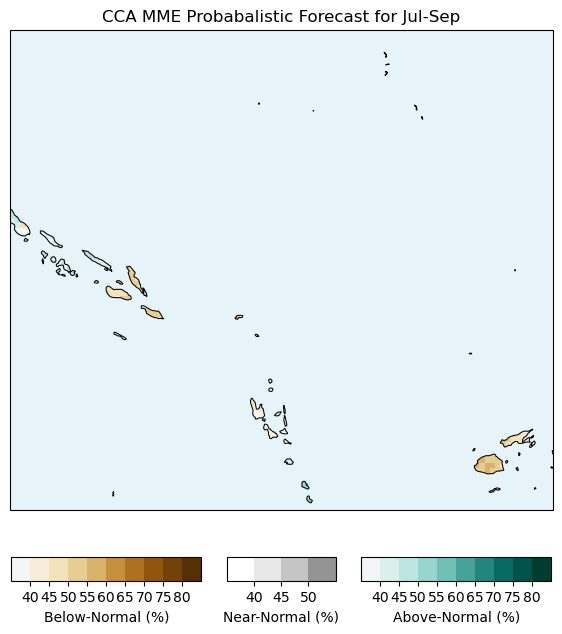

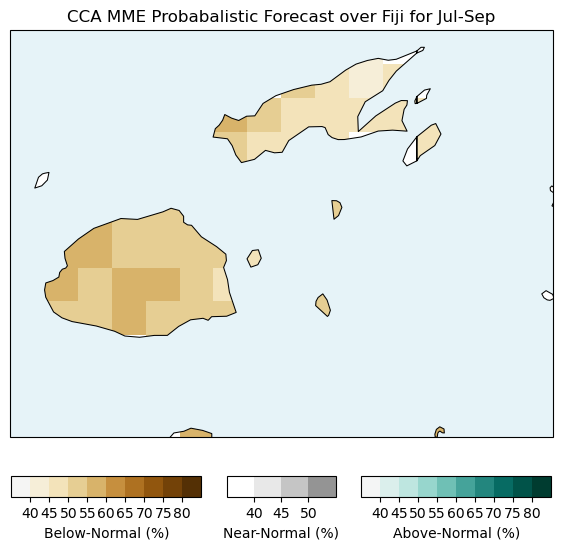

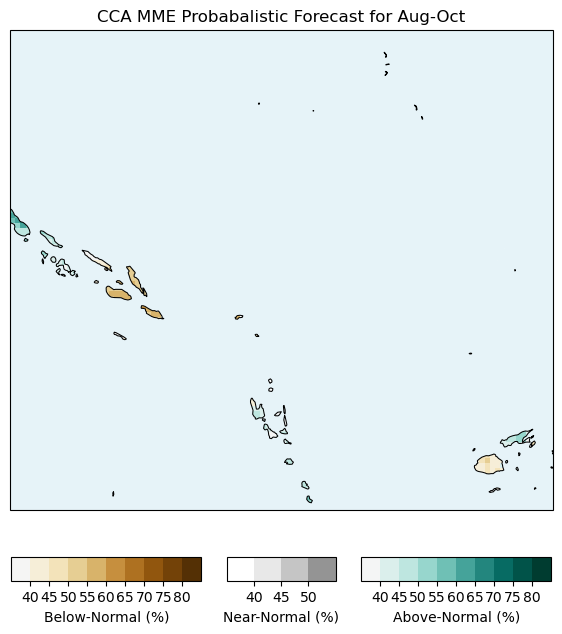

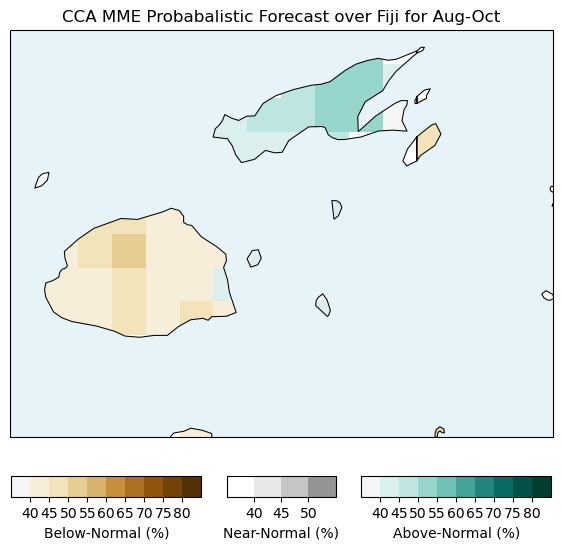

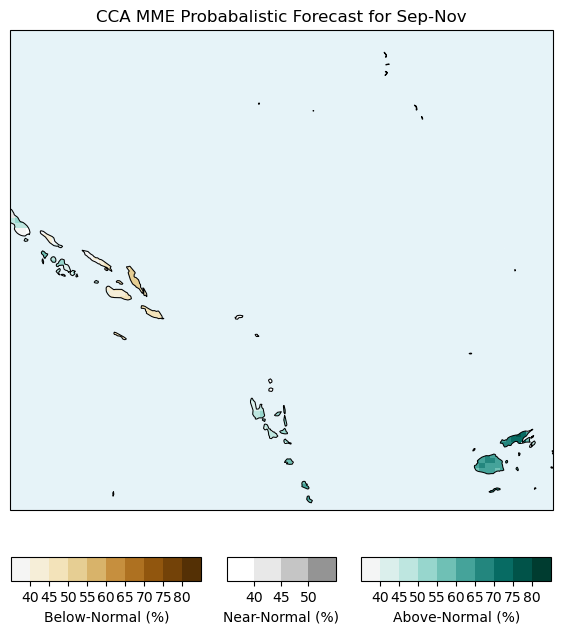

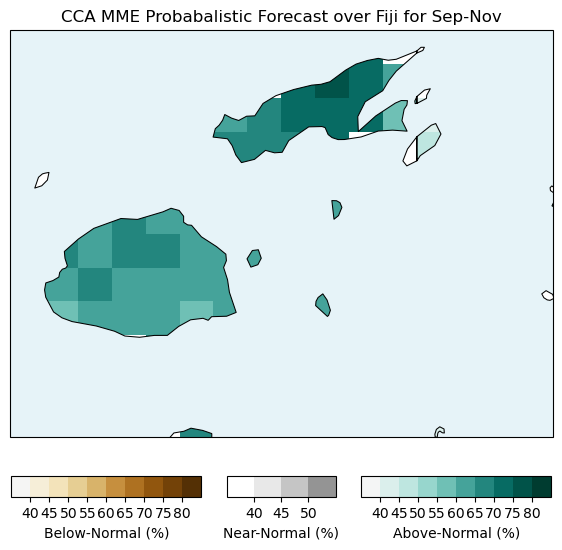

In [11]:
#plot the probabalistic output
from mprob import mview_probabilistic

# Iterate over each month and plot the data
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = xc.view_probabilistic(cca_fcsts_prob.isel(S=0, L=l), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_months[l] + 'CCA_forecast' + res + '.png'))

    im_fiji = xc.view_probabilistic(cca_fcsts_prob.isel(S=0, L=l).sel(X=slice(177, 183),
                                                                   Y=slice(-16, -19)), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast over Fiji for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_months[l] + 'Fiji_CCA_forecast' + res + '.png'))

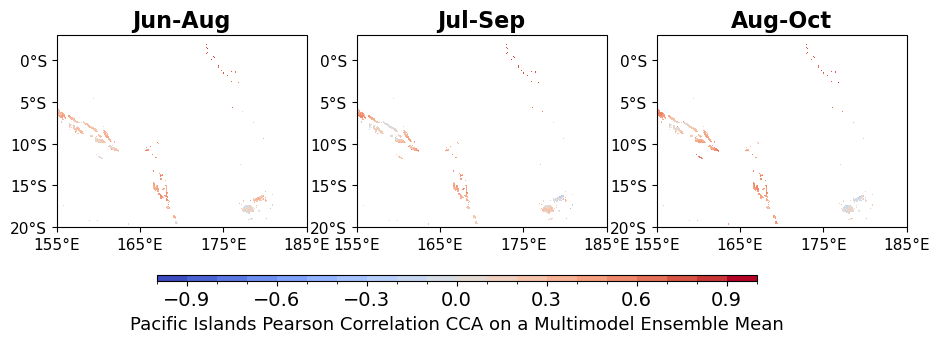

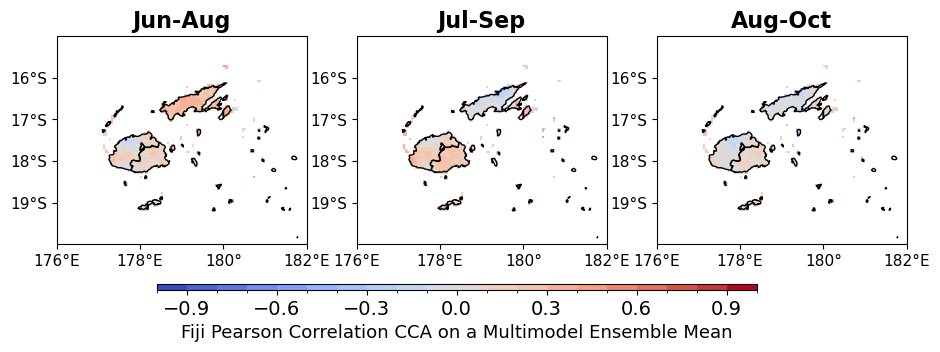

In [137]:
# Create a figure
fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =pearson_cca.isel(L=l).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=-1,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    # Set title with season name
    ax.set_title(download_args['target'][l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [155, 165,  175,  185]
    yticks = [-20,  -15,  -10, -5, 0]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['155°E', '165°E', '175°E', '185°E'])
    ax.set_yticklabels(['20°S', '15°S', '10°S', '5°S', '0°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Pacific Islands Pearson Correlation CCA on a Multimodel Ensemble Mean', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.savefig(os.path.join(figure_dir, 'pearson_CCA' + res), dpi=100)

fig = plt.figure(figsize=(10, 3))

# Iterate over each month and plot the data
for l, lead in enumerate(range(1, 4)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(1, 3, l+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =pearson_cca.isel(L=l).sel(X=slice(182, 177), Y=slice(-15, -20)).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=-1,vmax=1, levels = 21, cmap='coolwarm',add_colorbar=False)
    # Set title with season name
    ax.set_title(download_args['target'][l], fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    xticks = [176, 178, 180, 182]
    yticks = [-19,  -18,  -17, -16]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set the tick labels
    ax.set_xticklabels(['176°E', '178°E', '180°', '182°E'])
    ax.set_yticklabels(['19°S', '18°S', '17°S', '16°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fiji Pearson Correlation CCA on a Multimodel Ensemble Mean', fontsize=13)
cbar.ax.tick_params(labelsize=14)

# Show plot
plt.savefig(os.path.join(figure_dir, 'Fiji_pearson_CCA' + res), dpi=100)

#### Next Steps
1. Add environment install command to beginning of notebook
2. Test our environment is stable - install the environment on windows; and run this notebook
3. Test our environment is stable round two - instlal the environment on linux; and run this notebook
4. Give our document to others to test - Grace and Ehsan to run
5. Download data for other seasons (4 season skill) and upload to google drive
6. Run ELM, EOPLM, and CCA on 25km and 5km and time how long it takes
7. Add GROC skill score
8. Add RMSE skill score
9. Plot Raw Correlation score
10. Plot Bias Correlation score
11. Add Endalk's consolidated weighted ensemble mean based on correlation score
12. Develop an assignment for the practical session- divide into 4 teams; dividing by seasons - each calculate the raw score, bias corrected, plot the probabalistic forecast
13. Fix figure saving

Current run time for CCA
- 77 seconds for 25'; 35 seconds for 5km

In [ ]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
hindcasts_det.isel(M=0,time=3).plot()

In [ ]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [ ]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask